In [ ]:
import os
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

from gensim.models import FastText

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from tqdm import tqdm   #library that provides a fast, extensible progress bar for loops and iterables
tqdm.pandas()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from gensim.models import Word2Vec

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Embedding, Dense, Concatenate, Dropout,
    TimeDistributed, Lambda, RepeatVector, Activation, Layer
)
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import get_custom_objects
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA

# Train/Test Split
from sklearn.model_selection import train_test_split

# Evaluation (e.g., for abstractive summarization)
from bert_score import score

In [ ]:
# !pip install bert_score
# !pip install gensim

In [ ]:
# Load dataset
# ==== Google Drive Mount ====
from google.colab import drive
drive.mount('/content/drive')

# Example path update (you can change this)
DATA_PATH = '/content/drive/MyDrive/summerizer/'  # Change if needed

df = pd.read_csv(DATA_PATH+"BBCNewsData.csv")
print(df.shape)
df.info()

Mounted at /content/drive
(46897, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46897 entries, 0 to 46896
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       46897 non-null  object
 1   url      46897 non-null  object
 2   title    46897 non-null  object
 3   summary  46897 non-null  object
 4   text     46897 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


In [ ]:
df = df.drop(['id', 'url','title'],axis=1)
new_column_names = {
    'text': 'article',
    'summary':'summary',
}

# Rename the columns using the dictionary
df = df.rename(columns=new_column_names)
df.head()

,summary,article
0,بدأت القوات الأوكرانية الانسحاب من شبه جزيرة القرم.,وكان الرئيس الأوكراني المؤقت، الكسندر تورتشينوف، قد أمر بسحب جميع القوات الأوكرانية من القرم. وسيطرت قوات روسية صباح الاثنين على قاعدة بحرية أوكرانية في فيودوسيا، في ثالث هجوم من نوعه خلال 48 ساعة...
1,"""هل سيتم تغيير العبارة الشهيرة للمؤرخ اليوناني هيرودوت أن ""مصر هبة النيل""، تساؤل طرحه مدونون وناشطون مصريون على مواقع التواصل الإجتماعي بعد أن اعلنت الحكومة الإثيوبية بدء تحويل مجرى النيل الازرق أ...",بحلول عام 2050 ستحتاج مصر إلى 21 مليار متر مكعب فوق حصتها الحالية بحسب خبراء وأثار هذا الإعلان ردود فعل غاضبة في مصر وصل بعضها إلى التساؤل عن إمكانية تنفيذ عملية عسكرية ضد إثيوبيا لمنع بناء السد ل...
2,قالت الشرطة في القطاع الهندي من إقليم كشمير إن انفجار قنبلة أدى إلى مقتل 40 عنصرا على الأقل من قوات الأمن الخميس، بعد يوم من انفجار أدى لإصابة 12 تلميذا على الأقل.,"وذكرت وكالة الأنباء المحلية (جي.إن.إس) أن جماعة ""جيش محمد"" المتشددة أعلنت مسؤوليتها عن الهجوم. لكن ما هي منطقة كشمير المتنازع عليها بين الهند وباكستان؟ خلال العقود الست الماضية ظلت منطقة كشمير الق..."
3,في عام 816، تجول راهب يدعى كوكاي، في المنحدرات كثيفة الأشجار بجبل كويا (كويا سان) بمحافظة واكاياما اليابانية بحثا عن موقع مناسب لإقامة مقر لنشر تعاليم طائفة شينغون البوذية، التي أسسها حديثا.,ووقع اختياره على واد عمقه 800 متر محاط بثماني قمم حادة تشبه أوراق زهرة اللوتس ذات الثمانية أوراق. وبعد مرور 12 قرنا على وصول كوكاي إلى كويا سان، وبناء 117 معبدا، أدرجت منظمة اليونيسكو عالم كوكاي ا...
4,"أكد مصدر في ""الحراك التهامي"" لأبناء محافظة الحديدة لبي بي سي مقتل مسلح حوثي وإصابة ستة آخرين بالإضافة لجرح خمسة من مسلحي الحراك في اشتباكات اندلعت مساء امس الخميس بين الطرفين قرب ساحة اعتصام تابعة...","مسلح حوثي في إب وقال المصدر إن المسلحين الحوثيين هاجموا نشطاء الحراك التهامي لإفشال ترتيبات كانوا يجرونها لتنظيم حشود الجمعة تحت شعار "" رافضون "" للتنديد باجتياح المسلحين الحوثيين للمحافظة وترتيب م..."


In [ ]:
#Drop Duplicates and NA values
df.drop_duplicates(subset=['article'],inplace=True)
df.drop_duplicates(subset=['summary'],inplace=True)

df.dropna(axis=0,inplace=True)

In [ ]:
def load_sample_data(df, size=500, random_state=42):
    """
    Randomly select a subset of the dataset for testing the pipeline.

    Args:
        df (pd.DataFrame): Full dataset with 'Processed Text' and 'Processed Summary' columns.
        size (int): Number of samples to keep.
        random_state (int): For reproducibility.

    Returns:
        pd.DataFrame: Sampled dataframe
    """
    if size > len(df):
        raise ValueError("Requested sample size is larger than the dataset.")
    return df.sample(n=size, random_state=random_state).reset_index(drop=True)

In [ ]:
# Reduce to 500 samples for testing
data = df
df = load_sample_data(data, size=20000)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  20000 non-null  object
 1   article  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


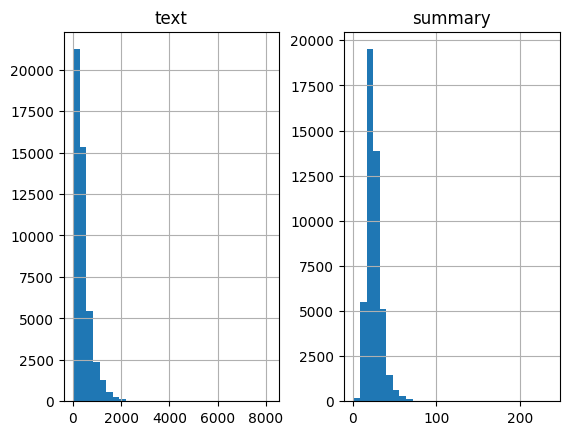

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['article']:
      text_word_count.append(len(i.split()))

for i in data['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
file_path = DATA_PATH + "Embeddings/"
# Load Word2Vec vectors from model
fasttext = FastText.load(file_path + "custom_fasttext_embeddings.model")

# Create embedding matrix for input (encoder) and output (decoder) vocabularies
embedding_dim = fasttext.vector_size

In [ ]:
print("embedding dimintion",embedding_dim)
fasttext.wv.get_vector('رئيس')

embedding dimintion 300


array([-1.59334794e-01,  3.56790185e-01,  1.82603374e-01,  3.93212050e-01,
        2.63258785e-01,  1.91462219e-01,  2.63870209e-01,  5.16008794e-01,
       -1.26093775e-01, -1.89314350e-01, -1.29823700e-01, -1.22639444e-02,
        2.00669989e-02, -1.85009465e-01, -3.48946787e-02,  4.74260412e-02,
        1.29445806e-01,  1.81024805e-01,  8.02409425e-02,  2.26679165e-03,
        5.83648458e-02,  7.94726536e-02,  7.16811493e-02, -1.37083679e-01,
        1.09987848e-01, -6.43984899e-02, -1.65450033e-02,  3.30748945e-01,
       -2.56016135e-01, -3.34675945e-02,  1.35691732e-01, -1.91595599e-01,
       -2.59513080e-01,  7.88071901e-02, -4.13684875e-01, -9.31537896e-02,
        1.88883394e-01,  1.02237135e-03, -1.03388198e-01, -5.65072298e-02,
        2.64621060e-03,  3.04305047e-01, -7.03647360e-02,  9.93510261e-02,
        2.77726620e-01, -6.47823587e-02, -1.90348059e-01,  3.10457230e-01,
       -4.73300457e-01, -4.15741652e-02, -4.14992720e-02,  8.83624852e-02,
       -3.51834036e-02, -

In [ ]:
from sklearn.model_selection import train_test_split
filtered_data = data
# --- Split the dataset ---
x_temp, x_test, y_temp, y_test = train_test_split(
    filtered_data['article'], filtered_data['summary'],
    test_size=0.1, random_state=0
)

x_tr_raw, x_val_raw, y_tr_raw, y_val_raw = train_test_split(
    x_temp, y_temp,
    test_size=0.1, random_state=0  # Now: 81% train, 9% val, 10% test
)

In [ ]:
# Parameters
max_len_text = 300
max_len_summary = 30
latent_dim = 256
learning_rate = 1e-3

In [ ]:
fasttext.wv.most_similar("وزير")

[('وزيرالخارجية', 0.7361931800842285),
 ('لوزير', 0.7235503196716309),
 ('ووزير', 0.6863083243370056),
 ('الوزير', 0.6745263934135437),
 ('بوزير', 0.6686405539512634),
 ('فوزير', 0.6682108640670776),
 ('وزيرها', 0.638404369354248),
 ('فالوزير', 0.6218865513801575),
 ('بالوزير', 0.6126304268836975),
 ('وزارة', 0.607886791229248)]

In [ ]:
import pickle

def save_tokenized_data(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_tokenized_data(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [ ]:
# Load tokenized datasets
# Define path
path = DATA_PATH + "BBC_Tokenized_Raw_Data/"
data_size = 20000
# Load full tokenized data
x_tr_tok = load_tokenized_data(path + "x_tr_tok.pkl")[:data_size]
x_val_tok = load_tokenized_data(path + "x_val_tok.pkl")[:data_size]
x_test_tok = load_tokenized_data(path + "x_test_tok.pkl")[:data_size]

y_tr_tok = load_tokenized_data(path + "y_tr_tok.pkl")[:data_size]
y_val_tok = load_tokenized_data(path + "y_val_tok.pkl")[:data_size]
y_test_tok = load_tokenized_data(path + "y_test_tok.pkl")[:data_size]

In [ ]:
#Add <sos> / <eos> to summaries
# Add <sos> and <eos>
def add_sos_eos(sequences):
    return ['<sos> ' + seq + ' <eos>' for seq in sequences]

y_tr_tok = add_sos_eos(y_tr_tok)
y_val_tok = add_sos_eos(y_val_tok)
y_test_tok = add_sos_eos(y_test_tok)

In [ ]:
# Fit Tokenizers
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_tr_tok)

y_tokenizer = Tokenizer(filters='',  oov_token="<OOV>")  # keep <sos> <eos> num_words=y_voc_size,
y_tokenizer.fit_on_texts(y_tr_tok)

In [54]:
#Convert and Pad Sequences
x_tr = pad_sequences(x_tokenizer.texts_to_sequences(x_tr_tok), maxlen=max_len_text, padding='post').astype('float32')
x_val = pad_sequences(x_tokenizer.texts_to_sequences(x_val_tok), maxlen=max_len_text, padding='post').astype('float32')
x_test = pad_sequences(x_tokenizer.texts_to_sequences(x_test_tok), maxlen=max_len_text, padding='post').astype('float32')

y_tr = pad_sequences(y_tokenizer.texts_to_sequences(y_tr_tok), maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_tokenizer.texts_to_sequences(y_val_tok), maxlen=max_len_summary, padding='post')
y_test = pad_sequences(y_tokenizer.texts_to_sequences(y_test_tok), maxlen=max_len_summary, padding='post')

In [55]:
# Vocabulary Sizes
x_voc_size = len(x_tokenizer.word_index) + 1
# y_voc_size = 30000
y_voc_size = len(y_tokenizer.word_index) + 1

# Build the embedding matrix for encoder and decoder

In [56]:
#Build Embedding Matrices
encoder_embedding_matrix = np.zeros((x_voc_size, embedding_dim))
for word, i in x_tokenizer.word_index.items():
    if word in fasttext.wv:
        encoder_embedding_matrix[i] = fasttext.wv[word]
    else:
        encoder_embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

decoder_embedding_matrix = np.zeros((y_voc_size, embedding_dim))
for word, i in y_tokenizer.word_index.items():
    if word in fasttext.wv:
        decoder_embedding_matrix[i] = fasttext.wv[word]
    else:
        decoder_embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [57]:
print("x_voc_size: ", x_voc_size)
print("y_voc_size: ", y_voc_size)

x_voc_size:  278230
y_voc_size:  54479


In [58]:
y_tr[:10]

array([[ 1152,   246,    75,     6,  2297,  1740,     6,    10,  1047,
            9,    58,  3271, 26201,  1341,  2517,  4800,     7, 14501,
           75,     6,   159,  1404,   453,   144,    10, 26202,   900,
         1817,     3,     5],
       [    4,  7416,   934,    47,     8,    37,    52,     8,  2431,
           24, 18404,  1565,   554,    46,  1313,     7,  1133,   858,
         4277,     6,   115,    67,   167,  2759,     3,     5,     0,
            0,     0,     0],
       [   67,   398,  1199,  2004,     2,   176,    13,     8,  6275,
         5788,     8,    48,  2432,     2,  2298,   339,  2366,   436,
            2,    56,   211,    53,  6815,  9139,    77,   390,     9,
         2850,     3,     5],
       [    4,  1452,   205, 18405,  3272, 10383,    35,    20,    29,
            9,   951, 18406,     9,  1153,  4527, 26203,  3053,  1673,
            6,   278,     8,   745,  1134,  2299,  3397,  3273,     8,
            3,     5,     0],
       [ 2518,     6,  2433,

In [59]:
import tensorflow as tf

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        encoder_shape, decoder_shape = input_shape

        self.W_a = self.add_weight(name='W_a',
                                   shape=(encoder_shape[2], encoder_shape[2]),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=(decoder_shape[2], encoder_shape[2]),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=(encoder_shape[2], 1),
                                   initializer='glorot_uniform',
                                   trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
      encoder_outputs, decoder_outputs = inputs

      # Expand decoder and encoder dims using tf.expand_dims instead of K.expand_dims
      decoder_expanded = tf.expand_dims(decoder_outputs, 2)   # (batch, dec_len, 1, dim)
      encoder_expanded = tf.expand_dims(encoder_outputs, 1)   # (batch, 1, enc_len, dim)

      # Attention score
      score = K.tanh(
        tf.linalg.matmul(encoder_expanded, self.W_a) + tf.linalg.matmul(decoder_expanded, self.U_a)
      )  # (batch, dec_len, enc_len, dim)

      # Apply attention weights
      score = tf.linalg.matmul(score, self.V_a)   # (batch, dec_len, enc_len, 1)
      score = tf.squeeze(score, axis=-1)          # (batch, dec_len, enc_len)
      attention_weights = tf.nn.softmax(score, axis=-1)  # (batch, dec_len, enc_len)

      # Compute context vector
      context = tf.matmul(attention_weights, encoder_outputs)  # (batch, dec_len, dim)

      return context, attention_weights

    def compute_output_shape(self, input_shape):
        encoder_shape, decoder_shape = input_shape
        return [
            tf.TensorShape((decoder_shape[0], decoder_shape[1], encoder_shape[2])),  # context
            tf.TensorShape((decoder_shape[0], decoder_shape[1], encoder_shape[1]))   # attention weights
        ]


In [60]:
es = EarlyStopping(
    monitor='val-loss',  # Primary metric to monitor
    mode='min',         # Minimize val_loss
    patience=5,         # Allow 5 epochs without improvement
    verbose=1,          # Show logs
    restore_best_weights=True,  # Revert to best weights
    min_delta=0.001,    # Minimum change to qualify as improvement
)

In [61]:
# ============================
# 1. Build Training Model
# ============================

def build_summarization_model(max_len_text, y_voc_size, latent_dim=300, embedding_dim=100):
    K.clear_session()

    # ----- Encoder -----
    encoder_text_input = Input(shape=(max_len_text,), name='encoder_text_input')
    enc_emb = Embedding(
        input_dim=encoder_embedding_matrix.shape[0],
        output_dim=encoder_embedding_matrix.shape[1],
        weights=[encoder_embedding_matrix],
        trainable=False,
        name="encoder_embedding"
    )(encoder_text_input)

    encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, name="encoder_lstm1", implementation=2)
    encoder_output1, _, _ = encoder_lstm1(enc_emb)

    encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, name="encoder_lstm2", implementation=2)
    encoder_output2, _, _ = encoder_lstm2(encoder_output1)

    encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, name="encoder_lstm3", implementation=2)
    encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

    # ----- Decoder -----
    decoder_inputs = Input(shape=(None,), name='decoder_input')
    dec_emb = Embedding(
        input_dim=decoder_embedding_matrix.shape[0],
        output_dim=decoder_embedding_matrix.shape[1],
        weights=[decoder_embedding_matrix],
        trainable=True,
        name="decoder_embedding"
    )(decoder_inputs)

    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_lstm", implementation=2)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    # ----- Attention -----
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, _ = attn_layer([encoder_outputs, decoder_outputs])

    decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attn_out])
    decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'), name="final_dense")
    decoder_outputs = decoder_dense(decoder_concat_input)

    model = Model(inputs=[encoder_text_input, decoder_inputs], outputs=decoder_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    return model

In [62]:
# Prepare decoder inputs (teacher forcing)
decoder_input_tr = y_tr[:, :-1].astype('float32') # Exclude last token
decoder_input_val = y_val[:, :-1].astype('float32')
decoder_input_test = y_test[:, :-1].astype('float32')

# 2. Prepare decoder outputs (shifted targets) - already done in your code
# Your existing reshaping is correct:
y_tr_out = y_tr[:, 1:].reshape((y_tr.shape[0], y_tr.shape[1]-1, 1))
y_val_out = y_val[:, 1:].reshape((y_val.shape[0], y_val.shape[1]-1, 1))
y_test_out = y_test[:, 1:].reshape((y_test.shape[0], y_test.shape[1]-1, 1))

In [63]:
# Build model
model = build_summarization_model(
    max_len_text,  # Your max text length
    y_voc_size,  # Your target vocab size
    latent_dim,    # LSTM units
    embedding_dim, # FastText dimension

)

# Prepare input dictionary with matching keys
train_data = {
    'encoder_text_input': x_tr,
    'doc_embedding_input': encoder_embedding_matrix[:len(x_tr)],
    'decoder_input': decoder_input_tr
}

val_data = {
    'encoder_text_input': x_val,
    'doc_embedding_input': encoder_embedding_matrix[len(x_tr):len(x_tr)+len(x_val)],
    'decoder_input': decoder_input_val
}


In [64]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_text_input  │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 300, 300)  │ 83,469,000 │ encoder_text_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm1       │ [(None, 300,      │    570,368 │ encoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm2       │ [(None, 300,      │    525,312 │ encoder_lstm1[0]… │
│ (LSTM)              │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 300) │ 16,343,700 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm3       │ [(None, 300,      │    525,312 │ encoder_lstm2[0]… │
│ (LSTM)              │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    570,368 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ encoder_lstm3[0]… │
│                     │ 256), (None,      │            │ encoder_lstm3[0]… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │    131,328 │ encoder_lstm3[0]… │
│ (AttentionLayer)    │ 256), (None,      │            │ decoder_lstm[0][… │
│                     │ None, 300)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 512) │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_dense         │ (None, None,      │ 27,947,727 │ concatenate[0][0] │
│ (TimeDistributed)   │ 54479)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 130,083,115 (496.23 MB)

 Trainable params: 46,614,115 (177.82 MB)

 Non-trainable params: 83,469,000 (318.41 MB)

In [65]:
# Compile the model
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [68]:
# Train with early stopping
history = model.fit(
    train_data,
    y_tr_out,
    batch_size=32,
    epochs=50,
    validation_data=(val_data, y_val_out),
    callbacks=[
        EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
        ModelCheckpoint('LSTM_BERT_best_summarizer.keras', monitor='val_loss', save_best_only=True)
    ]
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9679s 15s/step - accuracy: 0.1347 - loss: 8.3005 - val_accuracy: 0.2187 - val_loss: 6.9087
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9624s 15s/step - accuracy: 0.2211 - loss: 6.7422 - val_accuracy: 0.2248 - val_loss: 6.7810
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.2288 - loss: 6.5496 

In [39]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
# Add plot decorations
plt.title('Model Training Diagnostics', fontsize=14, pad=20)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

## extract the trained components from your best model

In [ ]:
# 7. Evaluation
test_results = model.evaluate(
    {
        'encoder_text_input': x_test,
        'doc_embedding_input': encoder_embedding_matrix[-len(x_test):],
        'decoder_input': decoder_input_test
    },
    y_test_out,
    batch_size=32
)

print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1238 - loss: 8.5057
Test Loss: 8.502386093139648, Test Accuracy: 0.12896551191806793


In [ ]:
# Print all layers with their indices
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} ({layer.__class__.__name__})")

Layer 0: encoder_text_input (InputLayer)
Layer 1: encoder_embedding (Embedding)
Layer 2: encoder_lstm1 (LSTM)
Layer 3: decoder_input (InputLayer)
Layer 4: encoder_lstm2 (LSTM)
Layer 5: decoder_embedding (Embedding)
Layer 6: encoder_lstm3 (LSTM)
Layer 7: decoder_lstm (LSTM)
Layer 8: attention_layer (AttentionLayer)
Layer 9: concatenate (Concatenate)
Layer 10: final_dense (TimeDistributed)


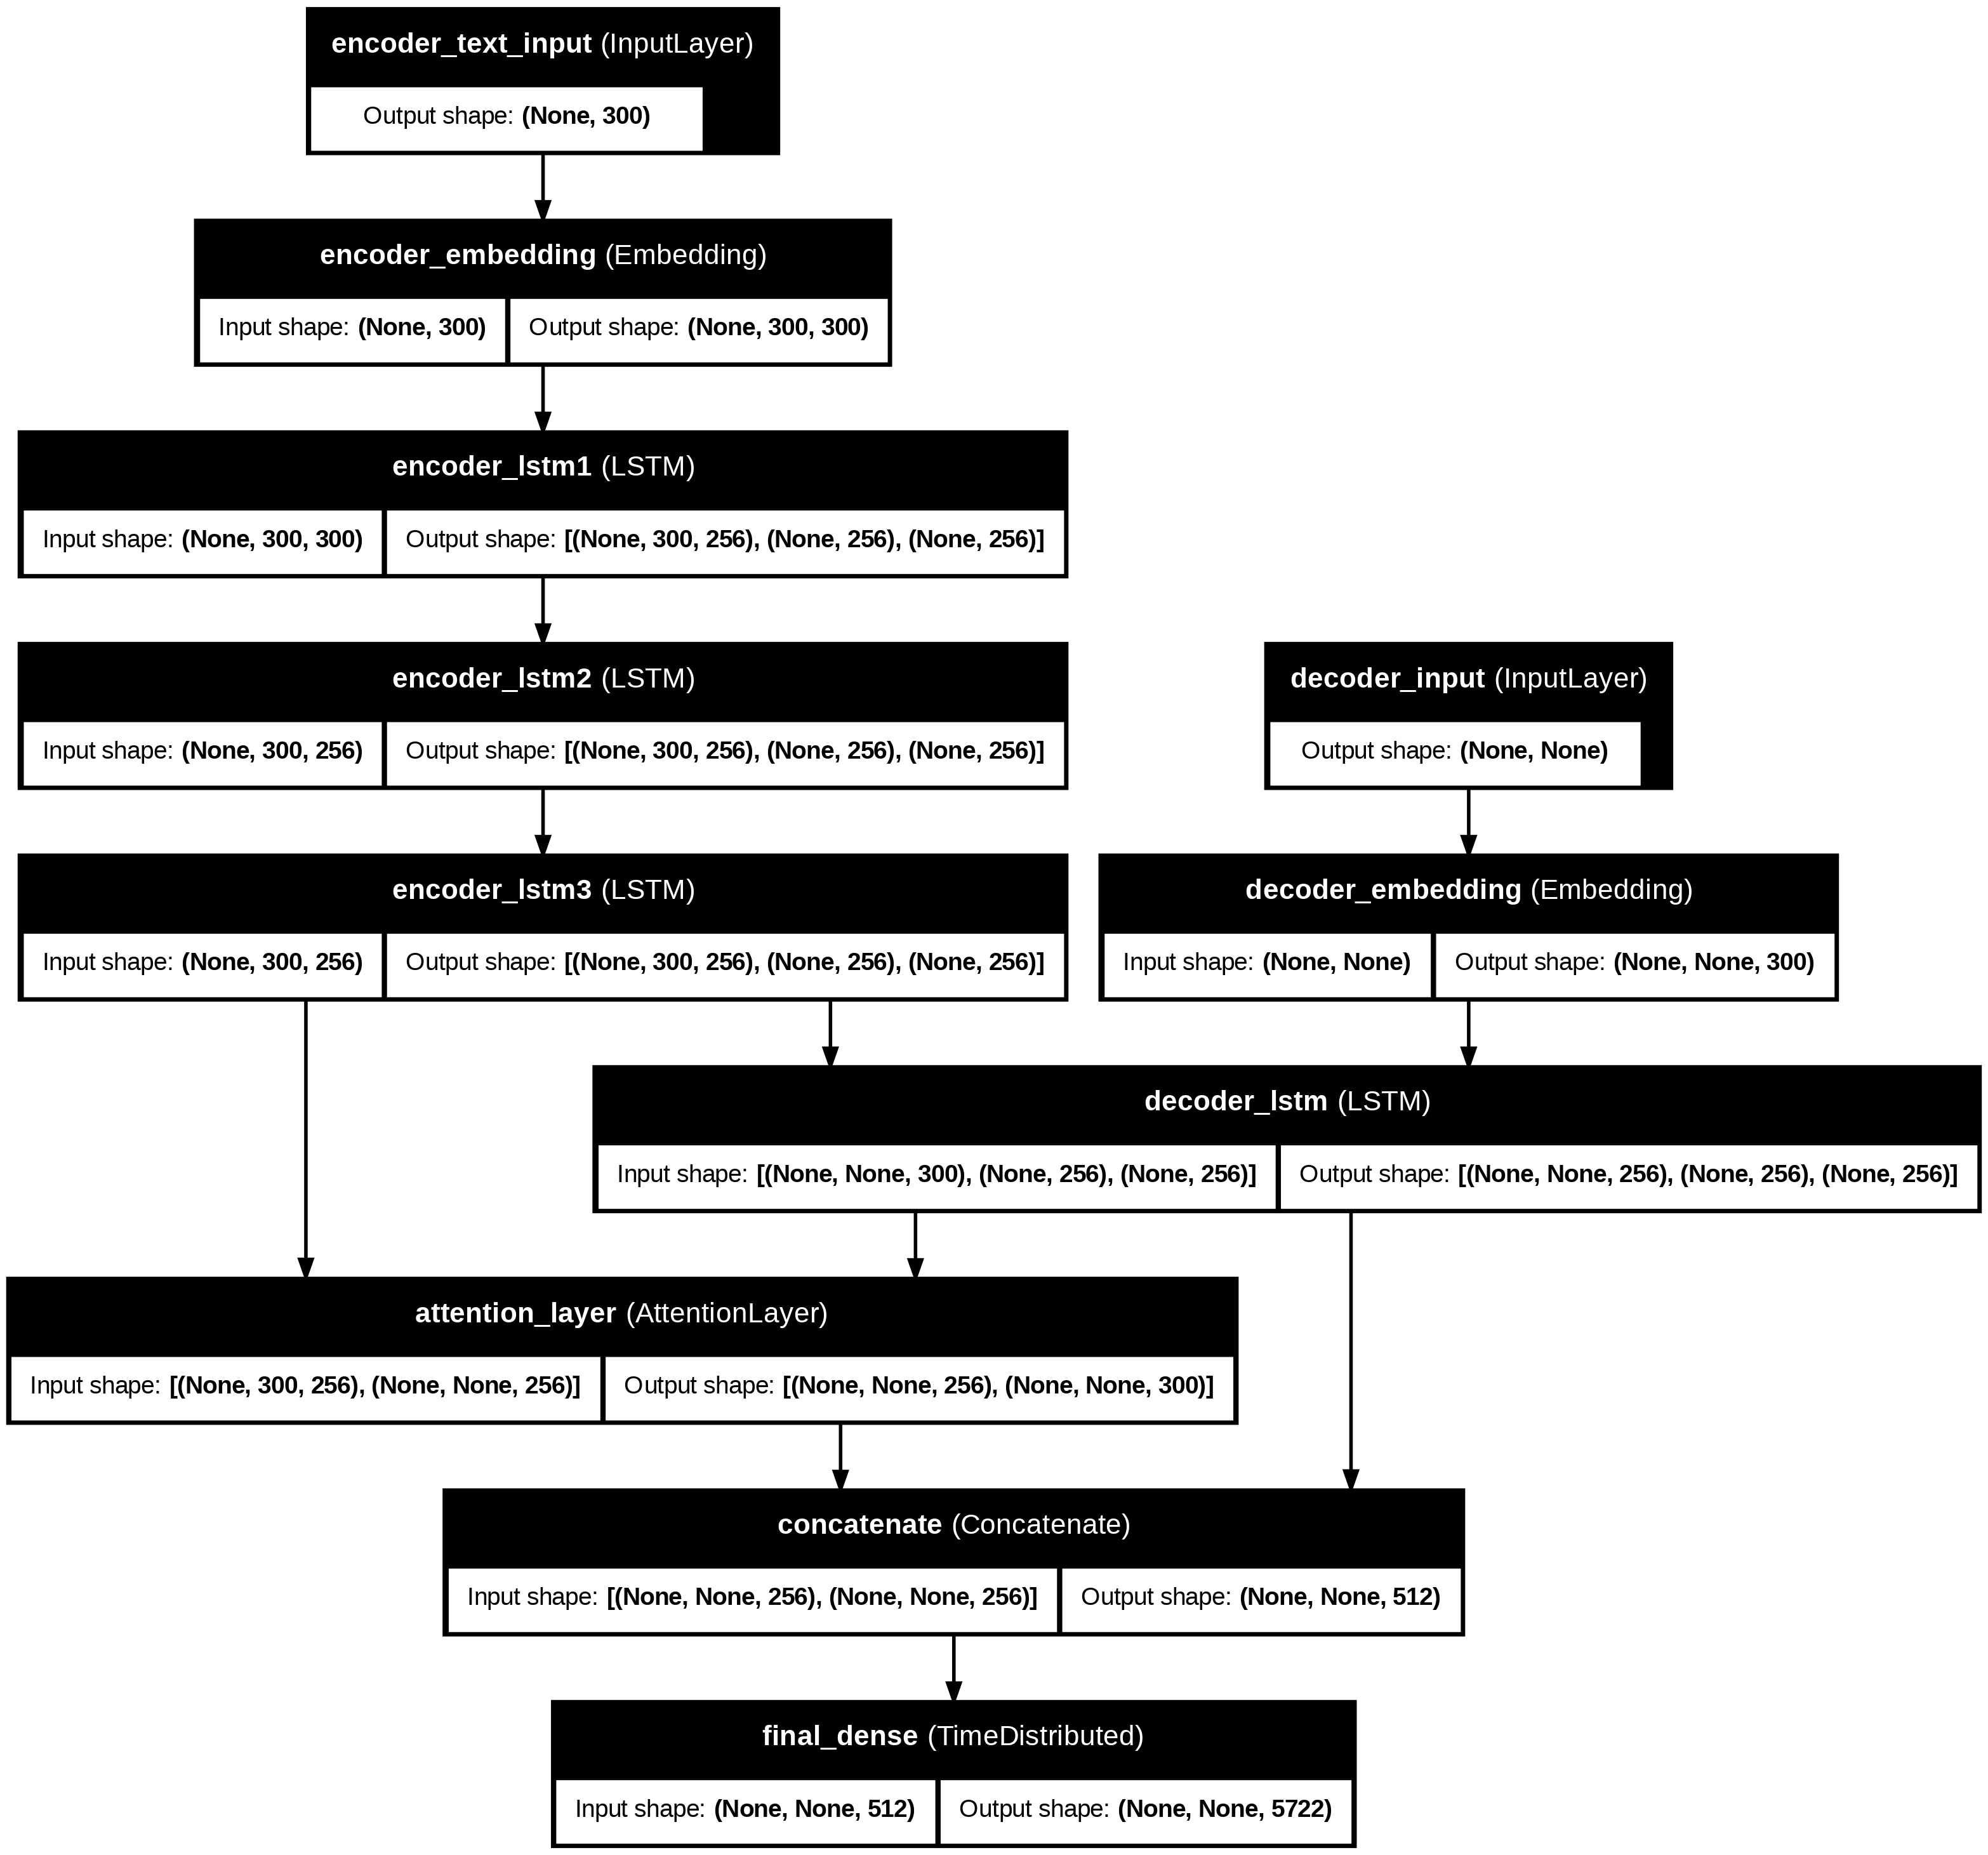

In [ ]:
from tensorflow.keras.utils import plot_model
# Save model plot to file
plot_model(
    model,
    to_file="model_architecture.png",
    show_shapes=True,           # shows input/output shapes on layers
    show_layer_names=True,      # shows layer names
    rankdir="TB",               # 'TB' = top to bottom, 'LR' = left to right
    expand_nested=True,         # expands nested models, if any
    dpi=200                     # higher resolution
)

## Build Decoder Inference Model

In [ ]:
# # Initialize and fit PCA on your document embeddings
pca = PCA(n_components=100)  # Reduce to 100 dimensions
document_embeddings_100d = pca.fit_transform(encoder_embedding_matrix)


In [ ]:
# First, make sure you have these mapping dictionaries
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [41]:
# ============================
# 2. Build Inference Model
# ============================

def build_inference_model(max_len_text, latent_dim=300):
    K.clear_session()

    # ----- Encoder -----
    encoder_text_input = Input(shape=(max_len_text,), name='encoder_text_input')
    enc_emb = Embedding(
        input_dim=encoder_embedding_matrix.shape[0],
        output_dim=encoder_embedding_matrix.shape[1],
        weights=[encoder_embedding_matrix],
        trainable=False,
        name="encoder_embedding"
    )(encoder_text_input)

    encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, name="encoder_lstm1", implementation=2)
    encoder_output1, _, _ = encoder_lstm1(enc_emb)

    encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, name="encoder_lstm2", implementation=2)
    encoder_output2, _, _ = encoder_lstm2(encoder_output1)

    encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, name="encoder_lstm3", implementation=2)
    encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

    # Store encoder model
    encoder_model = Model(inputs=encoder_text_input,
                          outputs=[encoder_outputs, state_h, state_c],
                          name='encoder_model')

    # ----- Decoder -----
    # These will be used during inference
    decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
    decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_input_c')
    decoder_encoder_outputs = Input(shape=(max_len_text, latent_dim), name='decoder_encoder_outputs')
    decoder_inputs = Input(shape=(1,), name='decoder_inputs_single')

    dec_emb = Embedding(
        input_dim=decoder_embedding_matrix.shape[0],
        output_dim=decoder_embedding_matrix.shape[1],
        weights=[decoder_embedding_matrix],
        trainable=True,
        name="decoder_embedding"
    )(decoder_inputs)

    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_lstm", implementation=2)
    decoder_outputs, state_h, state_c = decoder_lstm(dec_emb,
                                                   initial_state=[decoder_state_input_h,
                                                                  decoder_state_input_c])

    # ----- Attention -----
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([decoder_encoder_outputs, decoder_outputs])

    decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attn_out])
    decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'), name="final_dense")
    decoder_outputs = decoder_dense(decoder_concat_input)

    # Store decoder model
    decoder_model = Model(
        inputs=[decoder_inputs, decoder_encoder_outputs, decoder_state_input_h, decoder_state_input_c],
        outputs=[decoder_outputs, state_h, state_c],
        name='decoder_model'
    )

    return encoder_model, decoder_model

In [ ]:
# ============================
# 3. Generate Summary Function
# ============================

def generate_summary(input_sequence, encoder_model, decoder_model, y_tokenizer, max_len_summary=30):
    # Encode the input sequence
    enc_out, enc_h, enc_c = encoder_model.predict(input_sequence)

    # Initialize decoder states with encoder final states
    decoder_h, decoder_c = enc_h, enc_c

    # Start with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = y_tokenizer.word_index['<sos>']

    decoded_summary = []

    for i in range(max_len_summary):
        # Get next word
        output_tokens, decoder_h, decoder_c = decoder_model.predict(
            [target_seq, enc_out, decoder_h, decoder_c]
        )

        # Sample token with highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = y_tokenizer.index_word.get(sampled_token_index, '')

        # Stop if end token is generated
        if sampled_word == '<eos>':
            break

        decoded_summary.append(sampled_word)

        # Update target sequence for next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return ' '.join(decoded_summary)

In [ ]:
# Then build inference models
encoder_model, decoder_model = build_inference_model(max_len_text, latent_dim)

# Generate summary for a test sample
sample_idx = 0
input_seq = x_test[sample_idx:sample_idx+1]
reference_summary = y_tokenizer.sequences_to_texts([y_test[sample_idx]])[0]
generated_summary = generate_summary(input_seq, encoder_model, decoder_model, y_tokenizer, max_len_summary)

print("Original Text:", x_tokenizer.sequences_to_texts([x_test[sample_idx]])[0])
print("Reference Summary:", reference_summary)
print("Generated Summary:", generated_summary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━

In [ ]:
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

def evaluate_model(encoder_model, decoder_model, X_test, Y_test, y_tokenizer, reverse_y_index, max_summary_len, n_samples=50):
    rouge = Rouge()
    smoothie = SmoothingFunction().method4
    rouge_scores = []
    bleu_scores = []

    # Ensure n_samples is integer
    n_samples = int(min(n_samples, len(X_test)))

    for i in range(n_samples):
        # Generate summary
        input_seq = X_test[i:i+1]  # Get batch of 1
        decoded_summary = generate_summary(input_seq, encoder_model, decoder_model, y_tokenizer, max_summary_len)

        # Process reference summary - remove padding/special tokens
        reference_tokens = []
        for idx in Y_test[i]:
            if idx == 0:  # padding
                continue
            word = reverse_y_index.get(int(idx), '')  # Ensure idx is integer
            if word == '<eos>':
                break
            if word not in ['<sos>', '<pad>']:
                reference_tokens.append(word)
        reference_summary = ' '.join(reference_tokens)

        # Get original text (convert token IDs to words)
        original_tokens = []
        for idx in X_test[i]:
            if idx == 0:  # padding
                continue
            word = x_tokenizer.index_word.get(int(idx), '')
            original_tokens.append(word)
        original_text = ' '.join(original_tokens)

        # Skip empty summaries
        if not decoded_summary.strip() or not reference_summary.strip():
            continue

        # Calculate ROUGE
        try:
            scores = rouge.get_scores(decoded_summary, reference_summary)
            rouge_scores.append(scores[0])
        except:
            print(f"Skipping sample {i} due to ROUGE error")
            continue

        # Calculate BLEU
        try:
            bleu = sentence_bleu(
                [reference_summary.split()],
                decoded_summary.split(),
                smoothing_function=smoothie
            )
            bleu_scores.append(bleu)
        except:
            print(f"Skipping sample {i} due to BLEU error")
            continue

        print(f"\nSample {i+1}")
        print(f"Original: {original_text}")
        print(f"Predicted: {decoded_summary}")
        print(f"Reference: {reference_summary}")

    # Calculate averages
    avg_rouge = {
        'rouge-1': np.mean([s['rouge-1']['f'] for s in rouge_scores]) if rouge_scores else 0,
        'rouge-2': np.mean([s['rouge-2']['f'] for s in rouge_scores]) if rouge_scores else 0,
        'rouge-l': np.mean([s['rouge-l']['f'] for s in rouge_scores]) if rouge_scores else 0
    }
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0

    print("\n==== Evaluation Results ====")
    print(f"Evaluated {len(rouge_scores)} samples")
    print("Average ROUGE:", avg_rouge)
    print("Average BLEU:", avg_bleu)
    return avg_rouge, avg_bleu

In [ ]:
# Create reverse index mapping
# reverse_y_index = {int(k): v for k, v in y_tokenizer.word_index.items()}  # Ensure keys are integers

# Evaluate
avg_rouge, avg_bleu = evaluate_model(
    encoder_model,
    decoder_model,
    x_test,  # your test data
    y_test,
    y_tokenizer,
    reverse_y_index=reverse_target_word_index,
    max_summary_len = max_len_summary,
    n_samples=7  # can be float or int
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━

In [ ]:
# Evaluate
avg_rouge, avg_bleu = evaluate_model(
    encoder_model,
    decoder_model,
    x_test,  # your test data
    y_test,
    y_tokenizer,
    reverse_y_index=reverse_target_word_index,
    max_summary_len = max_len_summary,
    n_samples=7  # can be float or int
)